In [32]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [33]:
# 创建训练和测试数据集
train_data = datasets.FashionMNIST(root='../data/',
                                    train=True,
                                    transform=ToTensor(),
                                    download=False)
test_data = datasets.FashionMNIST(root='../data/', 
                                  train=False, 
                                  transform=ToTensor(),
                                  download=False)

In [34]:
# 创建DataLoader
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [35]:
# 定义一个简单的CNN网络
class Simple_CNN(nn.Module):

    # nn.Flatten()作为网络的一个​​可序列化层​​(模块)
    # 通常用于 nn.Sequential或自定义模型的 __init__中
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.linear1 = nn.Linear(in_features=16 * 16, out_features=120)
        self.linear2 = nn.Linear(in_features=120, out_features=84)
        self.linear3 = nn.Linear(in_features=84, out_features=10)


    # torch.flatten()是一个函数，不会​​作为网络层的一部分保存到模型结构中
    def forward(self, x):
        # input(N, 1, 28, 28)
        c1 = F.relu(self.conv1(x)) # (N, 6, 24, 24)
        s2 = F.max_pool2d(c1, (2, 2)) # (N, 6, 12, 12)
        c3 = F.relu(self.conv2(s2)) # (N, 16, 8, 8)
        s4 = F.max_pool2d(c3, 2) # (N, 16, 4, 4)
        s4_flattened = torch.flatten(s4, 1) # (N, 16 * 16)
        f5 = F.relu(self.linear1(s4_flattened)) # (N, 120)
        f6 = F.relu(self.linear2(f5)) # (N, 84)
        logits = self.linear3(f6) # (N, 10)
        return logits

model = Simple_CNN()
print(model)
        

Simple_CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=256, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)


In [36]:
# 定义损失和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [37]:
train_losses, test_losses = [], []
train_accs, test_accs = [], []

In [38]:
# 训练网络
batch_size = 64
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss, correct = 0, 0

    # image：形状为 (B, C, H, W)的张量
    # label：形状为 (B,)的张量，对应每个样本的标签
    for batch_idx, (image, label) in enumerate(dataloader):
        pred = model(image)
        loss = loss_fn(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    train_losses.append(avg_loss)
    train_accs.append(accuracy)
    print(f"Train: \n Accuracy = {100 * accuracy:>.1f}%, Avg Loss = {avg_loss:>.4f}")
    


In [39]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            pred = model(image)
            loss += loss_fn(pred, label).item()
            accuracy += (pred.argmax(1) == label).type(torch.float).sum().item()

    loss /= num_batches
    accuracy /= size
    test_losses.append(loss)
    test_accs.append(accuracy)
    print(f'Test: \n Accuracy = {(100*accuracy):>.1f}%, Avg Loss = {loss:>.4f}\n')

In [40]:
for epoch in range(10):
    print(f'Epoch:{epoch + 1}')
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch:1
Train: 
 Accuracy = 27.1%, Avg Loss = 1.9350
 
Test: 
 Accuracy = 56.4%, Avg Loss = 1.0363 

Epoch:2
Train: 
 Accuracy = 65.5%, Avg Loss = 0.8894
 
Test: 
 Accuracy = 70.0%, Avg Loss = 0.7897 

Epoch:3
Train: 
 Accuracy = 71.8%, Avg Loss = 0.7377
 
Test: 
 Accuracy = 72.5%, Avg Loss = 0.7281 

Epoch:4
Train: 
 Accuracy = 74.7%, Avg Loss = 0.6625
 
Test: 
 Accuracy = 75.2%, Avg Loss = 0.6558 

Epoch:5
Train: 
 Accuracy = 76.9%, Avg Loss = 0.6077
 
Test: 
 Accuracy = 77.4%, Avg Loss = 0.6055 

Epoch:6
Train: 
 Accuracy = 78.8%, Avg Loss = 0.5641
 
Test: 
 Accuracy = 79.0%, Avg Loss = 0.5811 

Epoch:7
Train: 
 Accuracy = 80.3%, Avg Loss = 0.5273
 
Test: 
 Accuracy = 80.5%, Avg Loss = 0.5359 

Epoch:8
Train: 
 Accuracy = 81.7%, Avg Loss = 0.4985
 
Test: 
 Accuracy = 80.7%, Avg Loss = 0.5170 

Epoch:9
Train: 
 Accuracy = 82.5%, Avg Loss = 0.4750
 
Test: 
 Accuracy = 81.2%, Avg Loss = 0.5256 

Epoch:10
Train: 
 Accuracy = 83.3%, Avg Loss = 0.4556
 
Test: 
 Accuracy = 82.6%, Avg Loss 

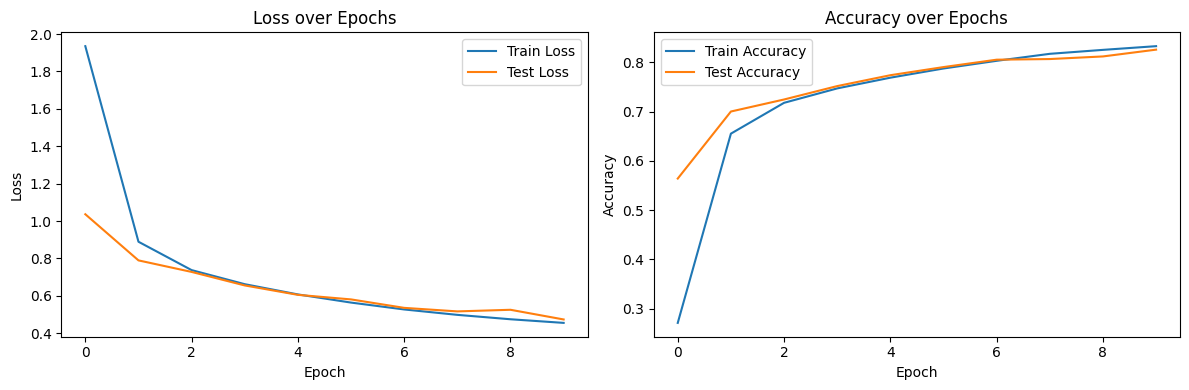

In [41]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.savefig('../outputs/figures/training_metrics.png')

plt.show()

In [42]:
model_path = '../outputs/checkpoints/SimpleCNN.pth'
print(model)
torch.save(model.state_dict(), model_path)

Simple_CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=256, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)
